In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow import keras
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, top_k_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from tensorflow.keras.applications import EfficientNetB0

In [3]:
## 定義圖片路徑
trainPath = '/kaggle/input/all-data-split/all_data_split/train'
validationPath = '/kaggle/input/all-data-split/all_data_split/val'
testPath = '/kaggle/input/all-data-split/all_data_split/test'

## 定義基本參數
imageSize = (300, 300)
imageShape = (300, 300, 3)
numofClass = 50
batchSize = 8
epoch = 8


## 定義 ImageDataGenerator (train)

trainDataGenerator = ImageDataGenerator(rescale = 1 / 255,
                      rotation_range=40,
                      width_shift_range = 0.3,
                      height_shift_range = 0.3,
                      shear_range = 0.3,
                      zoom_range = 0.2,
                      horizontal_flip = True,
                      fill_mode = 'nearest')


trainBatches = trainDataGenerator.flow_from_directory(directory = trainPath,
                            target_size = imageSize,
                            interpolation = 'bicubic',
                            class_mode = 'categorical',#生成one-hot 標籤
                            shuffle = True,
                            batch_size = batchSize)


## 定義 ImageDataGenerator (validation)
validateDataGenerator = ImageDataGenerator(rescale=1 / 255)
validateBatches = validateDataGenerator.flow_from_directory(directory = validationPath,
                            target_size = imageSize,
                            interpolation = 'bicubic',
                            class_mode = 'categorical',
                            shuffle = False,
                            batch_size = batchSize)

testDataGenerator = ImageDataGenerator(rescale=1/255)
testBatches = testDataGenerator.flow_from_directory(
    directory=testPath,
    target_size=imageSize,
    interpolation='bicubic',
    class_mode='categorical',
    shuffle=False,
    batch_size=batchSize
)



Found 86406 images belonging to 50 classes.
Found 11707 images belonging to 50 classes.
Found 11717 images belonging to 50 classes.


In [4]:
for cls, idx in trainBatches.class_indices.items():
    print('Class #{} = {}'.format(idx+1, cls))

Class #1 = 三杯雞
Class #2 = 什錦炒麵
Class #3 = 咖哩雞
Class #4 = 塔香海茸
Class #5 = 大陸妹
Class #6 = 客家小炒
Class #7 = 小番茄
Class #8 = 有機小松菜
Class #9 = 有機青松菜
Class #10 = 木瓜
Class #11 = 柳丁
Class #12 = 棗子
Class #13 = 橘子
Class #14 = 沙茶肉片
Class #15 = 油菜
Class #16 = 洋蔥炒蛋
Class #17 = 滷蛋
Class #18 = 滷雞腿
Class #19 = 玉米炒蛋
Class #20 = 瓜仔肉
Class #21 = 番茄炒蛋
Class #22 = 白米飯
Class #23 = 白菜滷
Class #24 = 福山萵苣
Class #25 = 空心菜
Class #26 = 糖醋雞丁
Class #27 = 紅蘿蔔炒蛋
Class #28 = 義大利麵
Class #29 = 芥藍菜
Class #30 = 菠菜
Class #31 = 葡萄
Class #32 = 蒜泥白肉
Class #33 = 蒸蛋
Class #34 = 蓮霧
Class #35 = 螞蟻上樹
Class #36 = 西瓜
Class #37 = 豆芽菜
Class #38 = 關東煮
Class #39 = 青江菜
Class #40 = 香蕉
Class #41 = 香酥魚排
Class #42 = 馬鈴薯燉肉
Class #43 = 高麗菜
Class #44 = 鳳梨
Class #45 = 鵝白菜
Class #46 = 鹽酥雞
Class #47 = 麥克雞塊
Class #48 = 麻婆豆腐
Class #49 = 麻油雞
Class #50 = 黑胡椒豬柳


In [5]:
# 設定 EfficientNetB0 權重檔案的本地路徑
weights_path = '/kaggle/input/efficientnet/efficientnetb0_notop .h5'

# 建立 EfficientNetB0 模型，載入權重
myModel = EfficientNetB0(include_top=False, weights=None, input_shape=imageShape)
myModel.load_weights(weights_path)  # 載入權重檔案

# 設置輸出層
x = myModel.output
x = Flatten()(x)
output_layer = Dense(units=numofClass, activation='softmax')(x)

myModel.trainable = True
finalModel = Model(inputs=myModel.input, outputs=output_layer)

# 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
finalModel.compile(optimizer = Adam(learning_rate=1e-3), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [6]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/finalModel.keras', verbose=1, save_best_only=True)


In [7]:
finalModel.fit(trainBatches,
              #steps_per_epoch=5,#(trainBatches.samples // batchSize)-1,
              validation_data=validateBatches,
              #validation_steps=5,#(validateBatches.samples // batchSize)-1,
              verbose=2,
              callbacks=[checkpointer],
              epochs=epoch)


Epoch 1/8


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733555697.603849      90 service.cc:145] XLA service 0x7aa19809ff80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733555697.603928      90 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733555697.603933      90 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1733555742.700893      90 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_loss improved from inf to 5.47665, saving model to /content/drive/MyDrive/finalModel.keras
10801/10801 - 4011s - 371ms/step - accuracy: 0.3684 - loss: 4.0419 - val_accuracy: 0.3527 - val_loss: 5.4767
Epoch 2/8

Epoch 2: val_loss improved from 5.47665 to 2.80484, saving model to /content/drive/MyDrive/finalModel.keras
10801/10801 - 3460s - 320ms/step - accuracy: 0.5198 - loss: 2.6754 - val_accuracy: 0.5936 - val_loss: 2.8048
Epoch 3/8

Epoch 3: val_loss did not improve from 2.80484
10801/10801 - 3465s - 321ms/step - accuracy: 0.5862 - loss: 2.1381 - val_accuracy: 0.4509 - val_loss: 5.0068
Epoch 4/8

Epoch 4: val_loss did not improve from 2.80484
10801/10801 - 3494s - 323ms/step - accuracy: 0.6260 - loss: 1.8364 - val_accuracy: 0.4953 - val_loss: 4.7019
Epoch 5/8

Epoch 5: val_loss improved from 2.80484 to 2.70185, saving model to /content/drive/MyDrive/finalModel.keras
10801/10801 - 3488s - 323ms/step - accuracy: 0.6542 - loss: 1.6113 - val_accuracy: 0.6264 - val_loss: 2.7

In [8]:
def get_predictions_and_labels(generator):
    preds = []
    labels = []
    steps = len(generator)
    for _ in range(steps):
        x, y = next(generator)
        preds.extend(finalModel.predict(x))
        labels.extend(y)
    return np.array(preds), np.array(labels)

predictions, true_labels = get_predictions_and_labels(testBatches)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━

In [9]:
# 計算 Top-1 Accuracy
top1_accuracy = accuracy_score(np.argmax(true_labels, axis=1), np.argmax(predictions, axis=1))

# 計算 Top-5 Accuracy
top5_accuracy = top_k_accuracy_score(np.argmax(true_labels, axis=1), predictions, k=5)

print(f"Top-1 Accuracy: {top1_accuracy}")
print(f"Top-5 Accuracy: {top5_accuracy}")


Top-1 Accuracy: 0.6712469062046599
Top-5 Accuracy: 0.8771016471793122


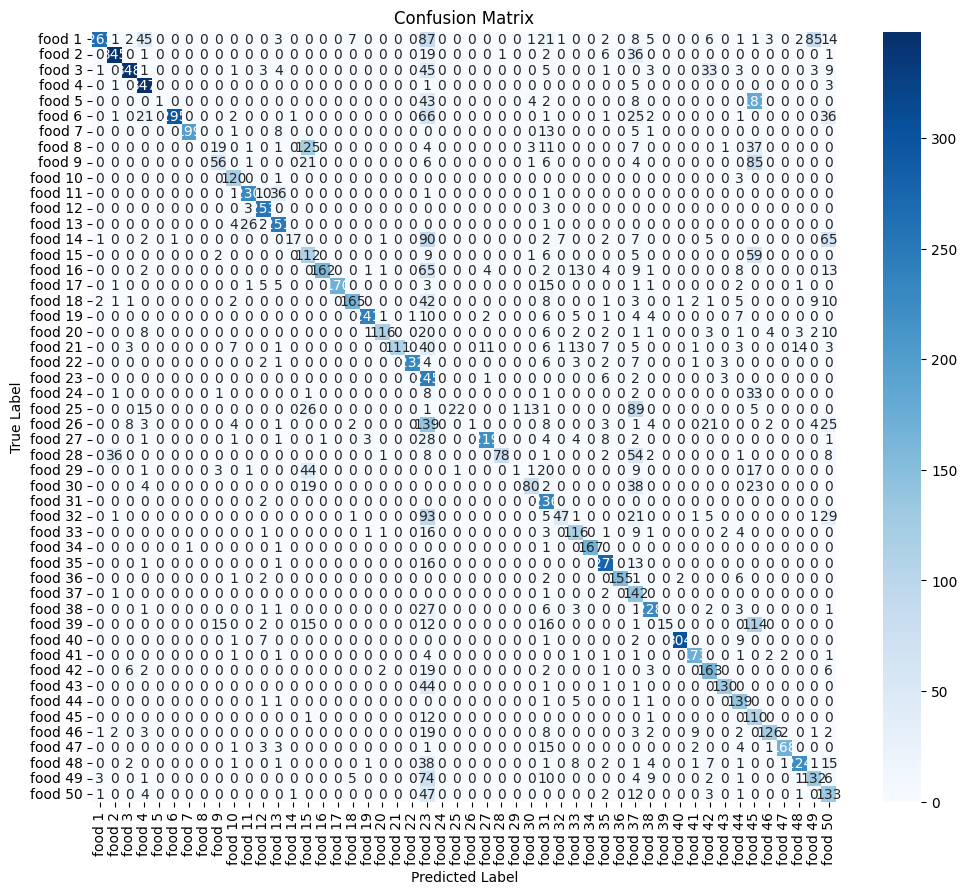

In [10]:
# 計算混淆矩陣
conf_matrix = confusion_matrix(np.argmax(true_labels, axis=1), np.argmax(predictions, axis=1))

# 獲取類別名稱，並按索引順序排序（改為使用 class0, class1, ...）
num_classes = len(testBatches.class_indices)
class_names = [f'food {i+1}' for i in range(num_classes)]

# 繪製混淆矩陣
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

